In [1]:

import _init_
from constants import * 
from set_path import *
from config import *
from functions import *

In [2]:
plt.rcParams['font.size']=28
plt.rcParams['axes.linewidth']=2.
plt.rcParams['xtick.major.size']=12
plt.rcParams['xtick.minor.size']=1
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=2.
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=12
plt.rcParams['ytick.minor.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=2
plt.rcParams['ytick.direction']='in'

In [3]:
home = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/'

data_path = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/')
pltfile = ['R8', 'R8-0.2Zsol']


In [4]:
file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10., 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [5]:

i=0
bins = 200
egas_arr = np.logspace(-25., -5., bins)
nH_arr   = np.logspace(-7.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [6]:
infile   = os.path.join(data_path, pltfile[1], 'metal_uniform.in')
# infile   = os.path.join(data_path, 'metal_uniform_512.in')
dom_min, dom_max, ncells = getdomain(infile)
fac = 1
zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
dy = (dom_max[1]- dom_min[1])/(fac*int(ncells[1]))
dz = (dom_max[2]- dom_min[2])/(fac*int(ncells[2]))
dV = dx * dy * dz

In [7]:
f = 'plt3610000'
inputfile = os.path.join(data_path, pltfile[1], f)
ds   = yt.load(inputfile)
ds.current_time.to('Myr')

yt : [INFO     ] 2024-09-21 15:44:30,607 Parameters: current_time              = 7105417624207872.0
yt : [INFO     ] 2024-09-21 15:44:30,609 Parameters: domain_dimensions         = [ 512  512 4096]
yt : [INFO     ] 2024-09-21 15:44:30,610 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-09-21 15:44:30,611 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


unyt_quantity(225.15709763, 'Myr')

In [8]:
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gas = np.array(data['gasDensity'])
eint    = np.array(data['gasInternalEnergy'])
np.amin(eint)

1.453289022438157e-20

In [9]:
egas0=eint
density = rho_gas
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]

idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

In [10]:
dx = (dom_max[0]- dom_min[0])/(1*int(ncells[0]))
dy = (dom_max[1]- dom_min[1])/(1*int(ncells[1]))
dz = (dom_max[2]- dom_min[2])/(1*int(ncells[2]))
dVol = dx*dy*dz

nH   = rho_gas/hydrogen_mass_cgs
mass = rho_gas * dVol
bins = 201

(dlow, dhigh)   = (1.e-6, 1.e2)
(tlow, thigh)   = (10., 2.e10)

zdisc = (np.abs(zrange)<300.*pc)
temp_disc = temp[:,:, zdisc]
nH_disc = nH[:,:, zdisc]
mass_disc = mass[:,:, zdisc]

dedges = np.logspace(np.log10(dlow), np.log10(dhigh), bins)
tedges = np.logspace(np.log10(tlow), np.log10(thigh), bins)

htot, binx, biny = np.histogram2d(nH.reshape(-1,1)[:,0], temp.reshape(-1,1)[:,0], \
                            bins=[dedges, tedges], weights=mass.reshape(-1,1)[:,0])

hout, binx, biny = np.histogram2d(nH_disc.reshape(-1,1)[:,0], temp_disc.reshape(-1,1)[:,0], \
                            bins=[dedges, tedges], weights=mass_disc.reshape(-1,1)[:,0])


In [11]:
volume = np.full(temp.shape, dVol)
zdisc = (np.abs(zrange)<300.*pc)
cold = (temp<500.)
warm = (temp>500.) & (temp<2.e4)

cold_disc = cold * zdisc
warm_disc = warm * zdisc

cold_volume = np.sum(np.ma.array(volume, mask=~cold_disc), axis=(0,1)).data
warm_volume = np.sum(np.ma.array(volume, mask=~warm_disc), axis=(0,1)).data

In [12]:
intm = (temp>2.e4) & (temp<1.e6)
hot = (temp>1.e6) 

int_disc = intm * zdisc
hot_disc = hot * zdisc

int_volume = np.sum(np.ma.array(volume, mask=~int_disc), axis=(0,1)).data
hot_volume = np.sum(np.ma.array(volume, mask=~hot_disc), axis=(0,1)).data

In [14]:
outputfile_name =os.path.join(data_path,'R8-0.2Zsol', 'histo_3610000.h5')

hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('DensBins'       , data=binx)
hfo.create_dataset('TempBins'       , data=biny)
hfo.create_dataset('TotalMass'       , data=htot)
hfo.create_dataset('ColdDiscVol'       , data=cold_volume)
hfo.create_dataset('WarmDiscVol'       , data=warm_volume)
hfo.create_dataset('IntDiscVol'       , data=int_volume)
hfo.create_dataset('HotDiscVol'       , data=hot_volume)
hfo.create_dataset('DiscMass'       , data=hout)
hfo.create_dataset('Timestep', data=timestep)
hfo.close()
print("--------Written file------->>",outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8-0.2Zsol/histo_3610000.h5


0.5668156165170162 0.43318438348298377 0.9218921069050914 86.92024049083584
2.4923599178089416e-05 0.9999750764008218 0.2855517527499522 0.8371699463463659


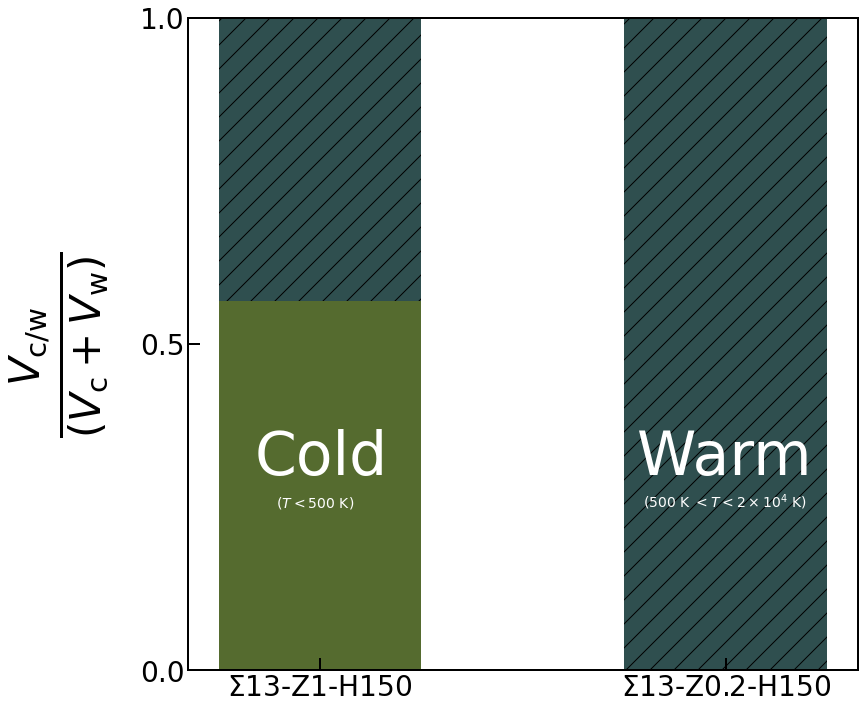

In [86]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0., 'hspace':0.04},figsize=(12, 12))
label = ['$\Sigma13-Z1$', '$\Sigma13-Z0.2$']
color = ['mediumvioletred', 'navy']
marker = ['*', 'o']
kk=0

path_home = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/'
file_list = ['R8/histo_6000000.h5', 'R8-0.2Zsol/histo_3610000.h5']
xlabel = [r'$\Sigma13$-Z$1$-H$150$', r'$\Sigma13$-Z$0.2$-H$150$']
label1 = [r'$T<500$ K', '']
label2 = ['', r'$500$ K $<T<2\times 10^4$ K']
for file in file_list:
    
    data_path = os.path.join(path_home, file)
    
    hf = h5py.File(data_path ,'r')
    cold_vol = (np.array(hf.get("ColdDiscVol")))
    warm_vol = (np.array(hf.get("WarmDiscVol")))
    int_vol = (np.array(hf.get("IntDiscVol")))
    hot_vol = (np.array(hf.get("HotDiscVol")))

    total_volume = kpc * kpc * 2 * 300. * pc
    total_volume = np.sum(cold_vol) + np.sum(warm_vol)
    
    cfrac = np.sum(cold_vol)/total_volume
    wfrac = np.sum(warm_vol)/total_volume
    ifrac = np.sum(int_vol)/total_volume
    hfrac = np.sum(hot_vol)/total_volume
    
    ax.bar(xlabel[kk], cfrac, color='darkolivegreen', label=label1[kk], width=0.5)
    ax.bar(xlabel[kk], wfrac, bottom=cfrac, color='darkslategrey', hatch='/', label=label2[kk], width=0.5)
    print(cfrac, wfrac, ifrac, hfrac)
#     ax.bar(xlabel[kk], np.sum(int_vol)/total_volume, color='orange', label='Int')
#     ax.bar(xlabel[kk], np.sum(hot_vol)/total_volume, color='black', label='Hot')
    kk+=1

ax.text(0.1, 0.3, 'Cold', transform=ax.transAxes, color='white', fontsize=60)
ax.text(0.125, 0.25, '\n ($T<500$ K)', transform=ax.transAxes, color='white', fontsize=14)

ax.text(0.67, 0.3, 'Warm', transform=ax.transAxes, color='white', fontsize=60)
ax.text(0.68, 0.25, r'($500$ K $<T< 2\times 10^4$ K)', transform=ax.transAxes, color='white', fontsize=14)

ax.set_ylim(0.0, 1.)
ax.set_ylabel(r'$\frac{V_{\rm c/w}}{(V_{\rm c}+V_{\rm w})}$', fontsize=60, labelpad=30)
ax.set_yticks([0.0, 0.5, 1.0])
# ax.legend(ncol=2, frameon=False, fontsize=26)
filename = fig_path +  '/Paper/volume_frac.jpeg'
plt.savefig(filename, bbox_inches='tight',  dpi=160)